In [599]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.metrics import r2_score
import category_encoders as catenc

import xgboost
from catboost import CatBoostRegressor,Pool

warnings.filterwarnings("ignore")

In [1084]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39499 entries, 0 to 39498
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Property_ID             39499 non-null  object 
 1   Property_Type           39499 non-null  object 
 2   Property_Area           39499 non-null  int64  
 3   Number_of_Windows       37845 non-null  float64
 4   Number_of_Doors         39499 non-null  int64  
 5   Furnishing              38457 non-null  object 
 6   Frequency_of_Powercuts  38116 non-null  float64
 7   Power_Backup            39499 non-null  object 
 8   Water_Supply            39499 non-null  object 
 9   Traffic_Density_Score   39499 non-null  float64
 10  Crime_Rate              38712 non-null  object 
 11  Dust_and_Noise          38280 non-null  object 
 12  Air_Quality_Index       39499 non-null  float64
 13  Neighborhood_Review     39499 non-null  float64
 14  Habitability_score      39499 non-null

#### Null values across dataset

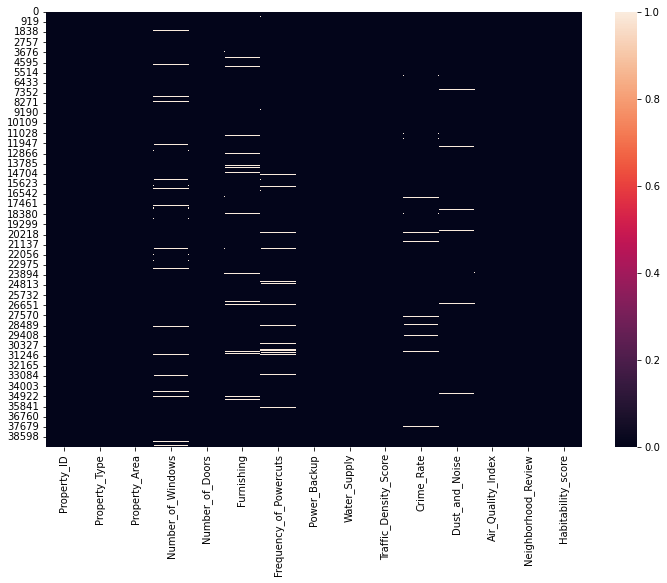

In [5]:
plt.figure(figsize=(12,8))
sns.heatmap(train.isna())
plt.show()

1. There is not a significant amount of null values in the data. i.e these null values can be handled and hence we don't have drop any of those.
2. Number_of_windows, Furnishing, Freq_pf_Powercuts, Crime_rate and Dust and noise features has some null values.

In [972]:
train.head()

,Property_ID,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
0,0x21e3,Apartment,106,NaN,1,Semi_Furnished,0.0,No,Once in a day - Morning,5.89,Slightly below average,Medium,90.0,3.86,71.98
1,0x68d4,Apartment,733,2.0,2,Unfurnished,1.0,No,Once in a day - Evening,4.37,Well below average,Medium,96.0,3.55,71.20
2,0x7d81,Apartment,737,4.0,2,Fully Furnished,0.0,No,Once in a day - Morning,7.45,Slightly below average,Medium,121.0,3.81,71.39
3,0x7a57,Apartment,900,3.0,2,Unfurnished,2.0,Yes,Once in a day - Morning,6.16,Well above average,Medium,100.0,1.34,31.46
4,0x9409,Bungalow,2238,14.0,6,Fully Furnished,0.0,No,All time,5.46,Well below average,Medium,116.0,4.77,93.70


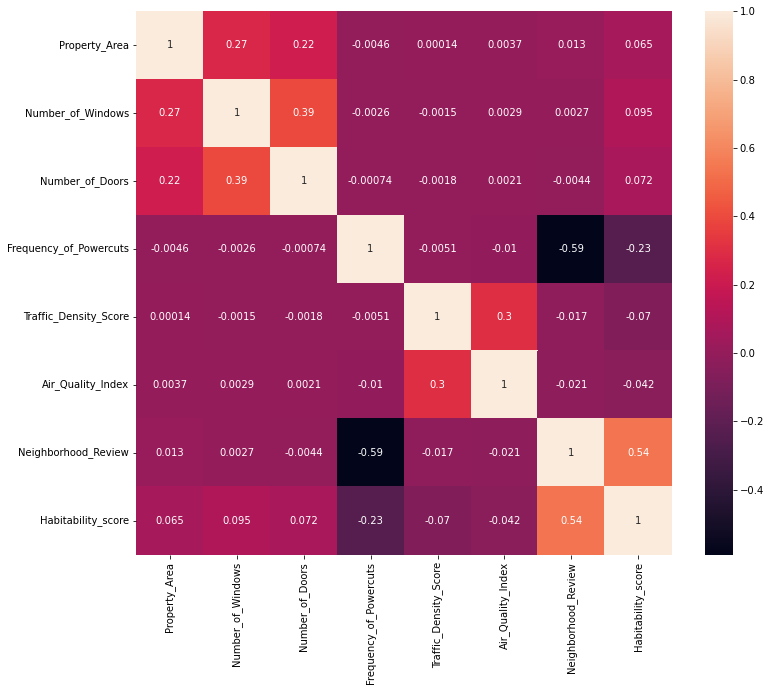

In [471]:
plt.figure(figsize=(12,10))
sns.heatmap(train.corr(),annot=True)

In [1085]:
categFeat = list()
numFeat = list()
for col in train.columns:
    if col in ['Habitability_score','Property_ID']:
        continue
    if train[col].dtype=="O":
        categFeat.append(col)
    else:
        numFeat.append(col)

In [795]:
print(f"Categorical features in the dataset are {categFeat} \n\nNumerical features in the dataset are {numFeat}.")

Categorical features in the dataset are ['Property_Type', 'Furnishing', 'Power_Backup', 'Water_Supply', 'Crime_Rate', 'Dust_and_Noise'] 

Numerical features in the dataset are ['Property_Area', 'Number_of_Windows', 'Number_of_Doors', 'Frequency_of_Powercuts', 'Traffic_Density_Score', 'Air_Quality_Index', 'Neighborhood_Review'].


#### Feature Engineering

In [1086]:
train['Property_Area'] = np.log(train['Property_Area'])
test['Property_Area'] = np.log(test['Property_Area'])

In [1087]:
train['nullCount'] = train.isnull().sum(axis=1)
test['nullCount'] = test.isnull().sum(axis=1)

# some more feature will be added after handling the missing values

### Let's first handle categorical features 
1. Water_Supply
2. Crime_Rate
3. Property_Type
4. Furnishing
5. Power_Backup
6. Dust_and_Noise

In [37]:
train[categFeat].isna().sum()

Property_Type        0
Furnishing        1042
Power_Backup         0
Water_Supply         0
Crime_Rate         787
Dust_and_Noise    1219
dtype: int64

#### Water Supply

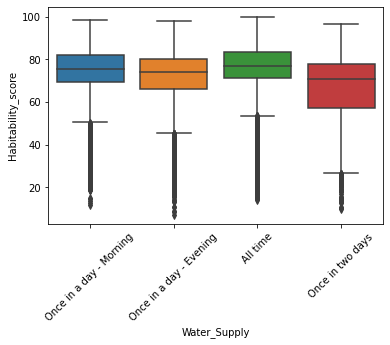

In [187]:
sns.boxplot(train['Water_Supply'],train['Habitability_score'])
plt.xticks(rotation=45)
plt.show()

In [980]:
train['Water_Supply'] = np.where(train['Water_Supply']=="NOT MENTIONED",'All time',train['Water_Supply'])
test['Water_Supply'] = np.where(test['Water_Supply']=="NOT MENTIONED",'All time',test['Water_Supply'])

#### Furnishing 

In [31]:
# train[train['Furnishing'].isna()]

In [1088]:
# before solving nan issue let's add one feature
train["isFurnishingNaN"] = train['Furnishing'].isna().apply(lambda k: 1 if k else 0)
test["isFurnishingNaN"] = test['Furnishing'].isna().apply(lambda k: 1 if k else 0)

In [1032]:
train['Furnishing'] = np.where(train['Furnishing'].isna(),'Not Available',train['Furnishing'])
test['Furnishing'] = np.where(test['Furnishing'].isna(),'Not Available',test['Furnishing'])

# train['Furnishing'] = np.where(train['Furnishing'].isna(),'Semi_Furnished',train['Furnishing'])
# test['Furnishing'] = np.where(test['Furnishing'].isna(),'Semi_Furnished',test['Furnishing'])

# for now let's give NaN in Furnishing a new group

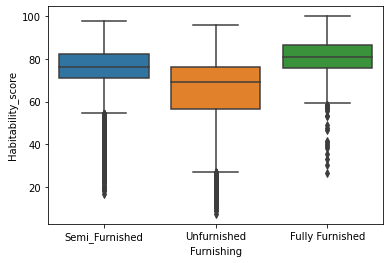

In [1058]:
# let's compare the Habitability_score for all fursnishing type
# One thing to observe below is the distribution of Semi_Furnished and new Group (not available) is almost same
# Can we label Not Available to Semi Furnished (don't do it if we do it it's called overfitting of data based on target features)
sns.boxplot(train['Furnishing'],train['Habitability_score'])

#### Crime Rate

In [45]:
# train[train['Crime_Rate'].isna()]

In [1089]:
# before solving nan issue let's add one feature for Crime Rate
train["isCrimeRateNaN"] = train['Crime_Rate'].isna().apply(lambda k: 1 if k else 0)
test["isCrimeRateNaN"] = test['Crime_Rate'].isna().apply(lambda k: 1 if k else 0)

In [1034]:
train['Crime_Rate'] = np.where(train['Crime_Rate'].isna(),'Not Available',train['Crime_Rate'])
test['Crime_Rate'] = np.where(test['Crime_Rate'].isna(),'Not Available',test['Crime_Rate'])

# train['Crime_Rate'] = np.where(train['Crime_Rate'].isna(),'Slightly below average',train['Crime_Rate'])
# test['Crime_Rate'] = np.where(test['Crime_Rate'].isna(),'Slightly below average',test['Crime_Rate'])

# for now let's give NaN in Furnishing a new group

C:\Users\pathak\Anaconda3\envs\analog\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


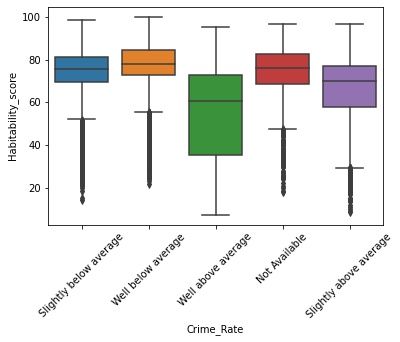

In [224]:
# One thing to note is the distribution of Slightly below average and new Group (not available) is almost same
# we will consider this if we need to improve our results
sns.boxplot(train['Crime_Rate'],train['Habitability_score'])
plt.xticks(rotation=45)
plt.show()

In [1090]:
# before solving nan issue let's add one feature for Dust_and_Noise
train["isDSNaN"] = train['Dust_and_Noise'].isna().apply(lambda k: 1 if k else 0)
test["isDSNaN"] = test['Dust_and_Noise'].isna().apply(lambda k: 1 if k else 0)

In [1036]:
train['Dust_and_Noise'] = np.where(train['Dust_and_Noise'].isna(),'Not Available',train['Dust_and_Noise'])
test['Dust_and_Noise'] = np.where(test['Dust_and_Noise'].isna(),'Not Available',test['Dust_and_Noise'])

# train['Dust_and_Noise'] = np.where(train['Dust_and_Noise'].isna(),'Medium',train['Dust_and_Noise'])
# test['Dust_and_Noise'] = np.where(test['Dust_and_Noise'].isna(),'Medium',test['Dust_and_Noise'])

# for now let's give NaN in Furnishing a new group

C:\Users\pathak\Anaconda3\envs\analog\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


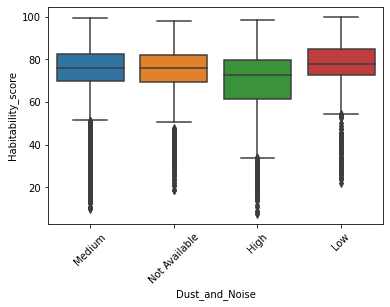

In [227]:
# One thing to note is the distribution of Medium D&S and new Group (not available) is almost same
# we will consider this if we need to improve our results
sns.boxplot(train['Dust_and_Noise'],train['Habitability_score'])
plt.xticks(rotation=45)
plt.show()

1. Now, that we have resolved all NaN issue in the category features. Let's Label Encode all of them one by one

#### Adding Some more features

In [1091]:
# crime rate + dust and noise
train['CR_and_DN'] = train['Crime_Rate']+'_'+train['Dust_and_Noise']
test['CR_and_DN'] = test['Crime_Rate']+'_'+test['Dust_and_Noise']

# property type + furnishing
train['Property_Furnishing'] = train['Property_Type']+'_'+train['Furnishing']
test['Property_Furnishing'] = test['Property_Type']+'_'+test['Furnishing']

# freq_of_pwercuts + Power_backup
train['Backup_Powercuts'] = train['Frequency_of_Powercuts'].astype(str)+ '_' + train['Power_Backup']
test['Backup_Powercuts'] = test['Frequency_of_Powercuts'].astype(str) + '_' + test['Power_Backup']

# AQI / TDS

train['AQI_TDS'] = train['Air_Quality_Index']/train['Traffic_Density_Score']
test['AQI_TDS'] = test['Air_Quality_Index']/test['Traffic_Density_Score']

In [1092]:
categFeat = list()
numFeat = list()
for col in train.columns:
    if col in ['Habitability_score','Property_ID']:
        continue
    if train[col].dtype=="O":
        categFeat.append(col)
    else:
        numFeat.append(col)

### Different ways of handling categorical data

#### One-hot encoding

In [762]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(train[categFeat])

OneHotEncoder(handle_unknown='ignore')

In [763]:
oneHotTrain = enc.transform(train[categFeat])
oneHotTest = enc.transform(test[categFeat])
newCol = [f"col_{i}" for i in range(oneHotTrain.shape[1])]
oneHotTrain = pd.DataFrame(oneHotTrain.toarray(),columns=newCol)
oneHotTest = pd.DataFrame(oneHotTest.toarray(),columns=newCol)

#### Target Encoding

In [1094]:
for feat in categFeat:
    encoder = catenc.TargetEncoder()  
    train[feat] = encoder.fit_transform(train[feat],train['Habitability_score'])
    test[feat] = encoder.transform(test[feat])

#### Categorical Value Mapping

In [815]:
dustMapping = dict(train.groupby('Dust_and_Noise')['Traffic_Density_Score'].mean())
train['Dust_and_Noise'] = train['Dust_and_Noise'].map(dustMapping)
dustMapping = dict(test.groupby('Dust_and_Noise')['Traffic_Density_Score'].mean())
test['Dust_and_Noise'] = test['Dust_and_Noise'].map(dustMapping)

In [816]:
crimeRateMap = {'Well below average': 1,
 'Slightly below average': 2,
 'Slightly above average': 4,
 'Well above average': 5,
 'Not Available': 3}

train['Crime_Rate'] = train['Crime_Rate'].map(crimeRateMap)
test['Crime_Rate'] = test['Crime_Rate'].map(crimeRateMap)

In [817]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39499 entries, 0 to 39498
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Property_ID             39499 non-null  object 
 1   Property_Type           39499 non-null  object 
 2   Property_Area           39499 non-null  float64
 3   Number_of_Windows       37845 non-null  float64
 4   Number_of_Doors         39499 non-null  int64  
 5   Furnishing              39499 non-null  object 
 6   Frequency_of_Powercuts  38116 non-null  float64
 7   Power_Backup            39499 non-null  object 
 8   Water_Supply            39499 non-null  object 
 9   Traffic_Density_Score   39499 non-null  float64
 10  Crime_Rate              39499 non-null  int64  
 11  Dust_and_Noise          39499 non-null  float64
 12  Air_Quality_Index       39499 non-null  float64
 13  Neighborhood_Review     39499 non-null  float64
 14  Habitability_score      39499 non-null

In [835]:
waterMapping = dict(train.groupby(['Water_Supply'])['Neighborhood_Review'].median())
train['Water_Supply'] = train['Water_Supply'].map(waterMapping)
waterMapping = dict(test.groupby(['Water_Supply'])['Neighborhood_Review'].median())
test['Water_Supply'] = test['Water_Supply'].map(waterMapping)

In [836]:
mapping = dict(train.groupby(['CR_and_DN'])['Neighborhood_Review'].median())
train['CR_and_DN'] = train['CR_and_DN'].map(waterMapping)
mapping = dict(test.groupby(['CR_and_DN'])['Neighborhood_Review'].median())
test['CR_and_DN'] = test['CR_and_DN'].map(waterMapping)

In [837]:
mapping = dict(train.groupby(['Property_Furnishing'])['Neighborhood_Review'].median())
train['Property_Furnishing'] = train['Property_Furnishing'].map(waterMapping)
mapping = dict(test.groupby(['Property_Furnishing'])['Neighborhood_Review'].median())
test['Property_Furnishing'] = test['Property_Furnishing'].map(waterMapping)

In [838]:
mapping = dict(train.groupby(['Backup_Powercuts'])['Neighborhood_Review'].median())
train['Backup_Powercuts'] = train['Backup_Powercuts'].map(waterMapping)
mapping = dict(test.groupby(['Backup_Powercuts'])['Neighborhood_Review'].median())
test['Backup_Powercuts'] = test['Backup_Powercuts'].map(waterMapping)

#### Label Encoding

In [1040]:
le_encoder = LabelEncoder()
for categorical_feature in categFeat:
    print(f"{categorical_feature} label encoding is done")
    train[categorical_feature] = le_encoder.fit_transform(train[categorical_feature])
    test[categorical_feature] = le_encoder.transform(test[categorical_feature])

Property_Type label encoding is done
Furnishing label encoding is done
Power_Backup label encoding is done
Water_Supply label encoding is done
Crime_Rate label encoding is done
Dust_and_Noise label encoding is done
CR_and_DN label encoding is done
Property_Furnishing label encoding is done
Backup_Powercuts label encoding is done


#### Now, let's handle Numerical missing data problem
1. Although, we can consider Number_of_Windows and Frequency_of_Powercuts as categorical features

In [1075]:
train[numFeat].isna().sum()

Property_Area                0
Number_of_Windows         1654
Number_of_Doors              0
Frequency_of_Powercuts    1383
Traffic_Density_Score        0
Air_Quality_Index            0
Neighborhood_Review          0
dtype: int64

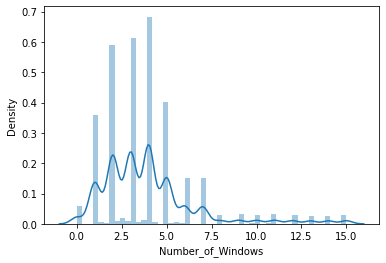

In [1119]:
sns.distplot(train['Number_of_Windows'])
# sns.boxplot(train['Property_Type'],train['Number_of_Windows'])
# plt.xticks(rotation=45)
# plt.show()

In [1097]:
# before solving nan issue let's add one feature for Dust_and_Noise
train["isNumWindows"] = train['Number_of_Windows'].isna().apply(lambda k: 1 if k else 0)
test["isNumWindows"] = test['Number_of_Windows'].isna().apply(lambda k: 1 if k else 0)

In [1120]:
propToWind = dict(train.groupby(['Property_Type'])['Number_of_Windows'].median())
propToWind

{71.29037256267411: 1.5,
 71.72941285283622: 2.6,
 73.54609803921574: 3.0,
 73.71554254219781: 5.6,
 74.88544131741754: 3.8,
 76.87768286927786: 9.0}

In [946]:
## filling missing values for Number_of_Windows feature

for idx in np.where(train['Number_of_Windows'].isna())[0]:
    train.at[idx,'Number_of_Windows'] = propToWind[train.at[idx,'Property_Type']]
    
for idx in np.where(test['Number_of_Windows'].isna())[0]:
    test.at[idx,'Number_of_Windows'] = propToWind[test.at[idx,'Property_Type']]

In [206]:
train['Number_of_Windows'] = np.where(train['Number_of_Windows'].isna(),'Not Available',train['Number_of_Windows'])
test['Number_of_Windows'] = np.where(test['Number_of_Windows'].isna(),'Not Available',test['Number_of_Windows'])



# for now let's give NaN in Furnishing a new group

C:\Users\pathak\Anaconda3\envs\analog\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\pathak\Anaconda3\envs\analog\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


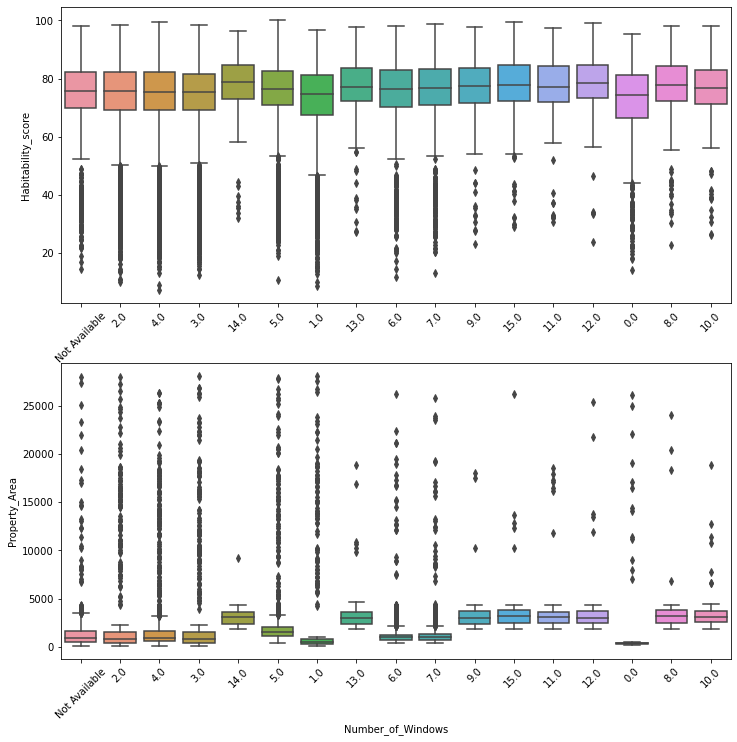

In [15]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.boxplot(train['Number_of_Windows'],train['Habitability_score'])
plt.xticks(rotation=45)

plt.subplot(2,1,2)
sns.boxplot(train['Number_of_Windows'],train['Property_Area'])
plt.xticks(rotation=45)
plt.show()

1. We can note that Missing samples has property area feature distribution as well as habitability_score distribution similar to number of windows as 4.
2. So, for now we will appoint missing values to score 4

In [94]:
# train['Number_of_Windows'] = np.where(train['Number_of_Windows']=='Not Available',4.0,train['Number_of_Windows'])
# test['Number_of_Windows'] = np.where(test['Number_of_Windows']=='Not Available',4.0,test['Number_of_Windows'])

#### Frequency_of_powercuts

In [1098]:
# before solving nan issue let's add one feature for Dust_and_Noise
train["isFreqPowerCuts"] = train['Frequency_of_Powercuts'].isna().apply(lambda k: 1 if k else 0)
test["isFreqPowerCuts"] = test['Frequency_of_Powercuts'].isna().apply(lambda k: 1 if k else 0)

In [947]:
# train['Frequency_of_Powercuts'] = np.where(train['Frequency_of_Powercuts'].isna(),'Not Available',train['Frequency_of_Powercuts'])
test['Frequency_of_Powercuts'] = np.where(test['Frequency_of_Powercuts'].isna(),'Not Available',test['Frequency_of_Powercuts'])

# for now let's give NaN in Furnishing a new group

C:\Users\pathak\Anaconda3\envs\analog\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\pathak\Anaconda3\envs\analog\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


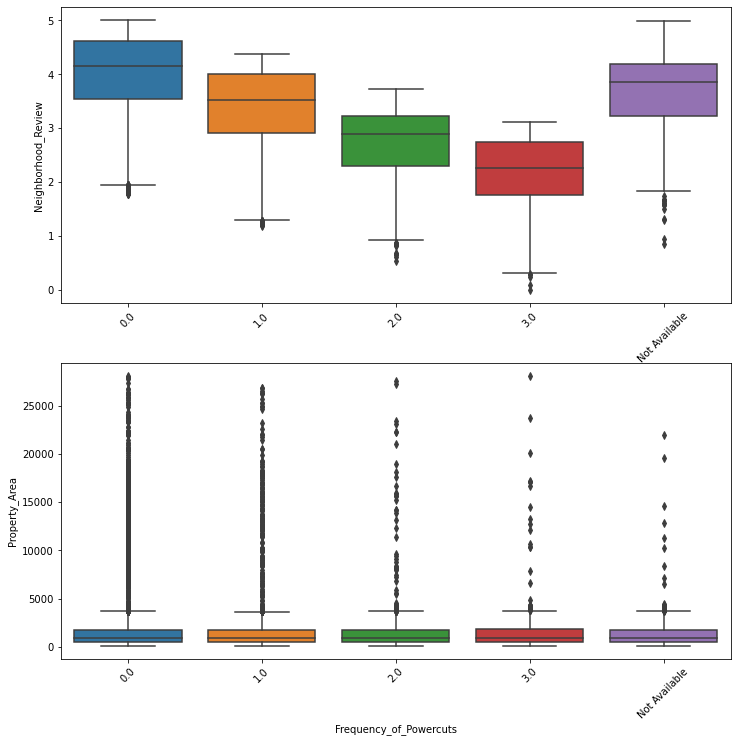

In [170]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.boxplot(train['Frequency_of_Powercuts'],train['Neighborhood_Review'])
plt.xticks(rotation=45)

plt.subplot(2,1,2)
sns.boxplot(train['Frequency_of_Powercuts'],train['Property_Area'])
plt.xticks(rotation=45)
plt.show()

In [949]:
# train['Frequency_of_Powercuts'] = np.where(train['Frequency_of_Powercuts']=='Not Available',4.0,train['Frequency_of_Powercuts'])
test['Frequency_of_Powercuts'] = np.where(test['Frequency_of_Powercuts']=='Not Available',4.0,test['Frequency_of_Powercuts'])

In [183]:
# train = train.replace(np. nan,'',regex=True)
# test = test.replace(np.nan,'',regex=True)

In [411]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39499 entries, 0 to 39498
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Property_ID             39499 non-null  object 
 1   Property_Type           39499 non-null  object 
 2   Property_Area           39499 non-null  float64
 3   Number_of_Windows       39499 non-null  float64
 4   Number_of_Doors         39499 non-null  int64  
 5   Furnishing              39499 non-null  object 
 6   Frequency_of_Powercuts  39499 non-null  object 
 7   Power_Backup            39499 non-null  object 
 8   Water_Supply            39499 non-null  object 
 9   Traffic_Density_Score   39499 non-null  float64
 10  Crime_Rate              39499 non-null  object 
 11  Dust_and_Noise          39499 non-null  object 
 12  Air_Quality_Index       39499 non-null  float64
 13  Neighborhood_Review     39499 non-null  float64
 14  Habitability_score      39499 non-null

In [772]:
## run below code if categorical encoding type is one-hot encoding

train = pd.concat([train.drop(categFeat,axis=1),oneHotTrain],axis=1)
test = pd.concat([test.drop(categFeat,axis=1),oneHotTest],axis=1)

#### Handling missing values using KNNImputer

In [1099]:
## Number_of_Windows
imputer = KNNImputer(n_neighbors=5)
tr = imputer.fit_transform(train[['Property_Type', 'Property_Area', 'Number_of_Windows','Number_of_Doors']])
ts = imputer.transform(test[['Property_Type', 'Property_Area', 'Number_of_Windows','Number_of_Doors']])
train['Number_of_Windows'] = tr[:,2]
test['Number_of_Windows'] = ts[:,2]

In [1100]:
## Frequency_of_Powercuts
imputer = KNNImputer(n_neighbors=5)
tr = imputer.fit_transform(train[['Frequency_of_Powercuts','Power_Backup','Neighborhood_Review']])
ts = imputer.transform(test[['Frequency_of_Powercuts','Power_Backup','Neighborhood_Review']])
train['Frequency_of_Powercuts'] = tr[:,0]
test['Frequency_of_Powercuts'] = ts[:,0]

In [1101]:
train['Number_of_Windows'] = train['Number_of_Windows'].astype(float)
test['Number_of_Windows'] = test['Number_of_Windows'].astype(float)

train['Frequency_of_Powercuts'] = train['Frequency_of_Powercuts'].astype(float)
test['Frequency_of_Powercuts'] = test['Frequency_of_Powercuts'].astype(float)

In [1102]:
train_y = pd.DataFrame(train["Habitability_score"])
train_x = train.drop(["Habitability_score","Property_ID"], axis=1)
testFinal = test.drop(['Property_ID'],axis=1)

### Catboost Regression

In [1113]:
N_FOLDS = 5
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=22)
y_oof = np.zeros(train_x.shape[0])
y_test = np.zeros(test.shape[0])
ix = 0
catboost_model = []
for train_ind, val_ind in skf.split(train_x, train_y):
    print(f"******* Fold {ix} ******* ")
    tr_x, val_x = (
        train_x.iloc[train_ind].reset_index(drop=True),
        train_x.iloc[val_ind].reset_index(drop=True),
    )
    tr_y, val_y = (
        train_y.iloc[train_ind].reset_index(drop=True),
        train_y.iloc[val_ind].reset_index(drop=True),
    )

    clf = CatBoostRegressor(iterations=5000,learning_rate=0.1,max_depth=5,random_state=42,loss_function='RMSE',verbose=True)
    clf.fit(tr_x, tr_y, eval_set=[(val_x, val_y)],  verbose=100)
    catboost_model.append(clf)
#     clf =  CatBoostRegressor(n_estimators=200,
#                        loss_function='RMSE',
#                        learning_rate=0.3,
#                        depth=5, task_type='CPU',
#                        random_state=1,
#                        verbose=False)
#     pool_train = Pool(tr_x, tr_y,
#                   cat_features = categFeat)
    
#     pool_val = Pool(val_x,val_y,cat_features = categFeat)

#     pool_test = Pool(test, cat_features = categFeat)
    
#     clf.fit(pool_train)
    
#     preds = clf.predict(pool_val)
    preds = clf.predict(val_x)
    y_oof[val_ind] = y_oof[val_ind] + preds

#     preds_test = clf.predict(pool_test)
    preds_test = clf.predict(testFinal)
    y_test = y_test + preds_test / N_FOLDS
    ix = ix + 1

******* Fold 0 ******* 
0:	learn: 13.2514139	test: 13.3169095	best: 13.3169095 (0)	total: 7.62ms	remaining: 38.1s
100:	learn: 6.3890888	test: 6.4990445	best: 6.4990445 (100)	total: 455ms	remaining: 22.1s
200:	learn: 6.1072835	test: 6.2976565	best: 6.2976565 (200)	total: 848ms	remaining: 20.3s
300:	learn: 5.9440085	test: 6.2193953	best: 6.2191265 (298)	total: 1.27s	remaining: 19.8s
400:	learn: 5.8321432	test: 6.1738812	best: 6.1738812 (400)	total: 1.66s	remaining: 19s
500:	learn: 5.7428764	test: 6.1489871	best: 6.1489871 (500)	total: 2.05s	remaining: 18.4s
600:	learn: 5.6696677	test: 6.1474671	best: 6.1471139 (598)	total: 2.44s	remaining: 17.9s
700:	learn: 5.6081170	test: 6.1403026	best: 6.1403026 (700)	total: 2.84s	remaining: 17.4s
800:	learn: 5.5433537	test: 6.1297496	best: 6.1297496 (800)	total: 3.26s	remaining: 17.1s
900:	learn: 5.4913867	test: 6.1322785	best: 6.1273326 (827)	total: 3.68s	remaining: 16.7s
1000:	learn: 5.4364780	test: 6.1286857	best: 6.1273326 (827)	total: 4.08s	rema

3800:	learn: 4.5515578	test: 6.1487359	best: 6.1173546 (1197)	total: 15.1s	remaining: 4.76s
3900:	learn: 4.5292234	test: 6.1519132	best: 6.1173546 (1197)	total: 15.5s	remaining: 4.36s
4000:	learn: 4.5096499	test: 6.1520955	best: 6.1173546 (1197)	total: 15.9s	remaining: 3.97s
4100:	learn: 4.4876491	test: 6.1534535	best: 6.1173546 (1197)	total: 16.3s	remaining: 3.57s
4200:	learn: 4.4674535	test: 6.1569013	best: 6.1173546 (1197)	total: 16.7s	remaining: 3.17s
4300:	learn: 4.4477569	test: 6.1624002	best: 6.1173546 (1197)	total: 17.1s	remaining: 2.78s
4400:	learn: 4.4285993	test: 6.1634382	best: 6.1173546 (1197)	total: 17.5s	remaining: 2.38s
4500:	learn: 4.4076929	test: 6.1647582	best: 6.1173546 (1197)	total: 17.9s	remaining: 1.98s
4600:	learn: 4.3890220	test: 6.1663787	best: 6.1173546 (1197)	total: 18.3s	remaining: 1.58s
4700:	learn: 4.3680961	test: 6.1684964	best: 6.1173546 (1197)	total: 18.6s	remaining: 1.19s
4800:	learn: 4.3506026	test: 6.1700116	best: 6.1173546 (1197)	total: 19s	remaini

2400:	learn: 4.9066877	test: 6.0465302	best: 6.0399037 (1896)	total: 9.43s	remaining: 10.2s
2500:	learn: 4.8773136	test: 6.0490443	best: 6.0399037 (1896)	total: 9.81s	remaining: 9.8s
2600:	learn: 4.8505414	test: 6.0507237	best: 6.0399037 (1896)	total: 10.2s	remaining: 9.4s
2700:	learn: 4.8219903	test: 6.0506428	best: 6.0399037 (1896)	total: 10.6s	remaining: 9.01s
2800:	learn: 4.7934788	test: 6.0515441	best: 6.0399037 (1896)	total: 11s	remaining: 8.62s
2900:	learn: 4.7659930	test: 6.0503126	best: 6.0399037 (1896)	total: 11.4s	remaining: 8.23s
3000:	learn: 4.7386570	test: 6.0504855	best: 6.0399037 (1896)	total: 11.8s	remaining: 7.83s
3100:	learn: 4.7114982	test: 6.0506339	best: 6.0399037 (1896)	total: 12.1s	remaining: 7.44s
3200:	learn: 4.6881520	test: 6.0525630	best: 6.0399037 (1896)	total: 12.5s	remaining: 7.04s
3300:	learn: 4.6631077	test: 6.0547660	best: 6.0399037 (1896)	total: 12.9s	remaining: 6.66s
3400:	learn: 4.6390728	test: 6.0579249	best: 6.0399037 (1896)	total: 13.3s	remaining

#### Xgboost Model

In [1047]:
# N_FOLDS = 5
# skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
# y_oof_xgb = np.zeros(train_x.shape[0])
# y_test_xgb = np.zeros(testFinal.shape[0])
# ix = 0

# xgb_parms = { 
#     'max_depth':4, 
#     'learning_rate':0.1, 
#     'subsample':0.8, 
#     'eval_metric':'rmsle',
#     'objective':'reg:squarederror',
#     'tree_method':'hist',
#     'predictor':'cpu_predictor',
#     'random_state':42
# }

# for train_ind, val_ind in skf.split(train_x, train_y):
#     print(f"******* Fold {ix} ******* ")
#     tr_x, val_x = (
#         train_x.iloc[train_ind].reset_index(drop=True),
#         train_x.iloc[val_ind].reset_index(drop=True),
#     )
#     tr_y, val_y = (
#         train_y.iloc[train_ind].reset_index(drop=True),
#         train_y.iloc[val_ind].reset_index(drop=True),
#     )
    
#     dtrain = xgb.DMatrix(data=tr_x, label=tr_y)
#     dvalid = xgb.DMatrix(data=val_x, label=val_y)
#     dtest = xgb.DMatrix(data=testFinal)

#     clf = xgb.train(xgb_parms, 
#                 dtrain=dtrain,
#                 evals=[(dtrain,'train'),(dvalid,'valid')],
#                 num_boost_round=9999,
#                 early_stopping_rounds=100,
#                 verbose_eval=100) 
                        
    
#     preds = clf.predict(dvalid)
#     y_oof_xgb[val_ind] = y_oof_xgb[val_ind] + preds

# #     preds_test = clf.predict(pool_test)
#     preds_test = clf.predict(dtest)
#     y_test_xgb = y_test_xgb + preds_test / N_FOLDS
#     ix = ix + 1

#### LightGBM Model

In [1048]:
# N_FOLDS = 5
# skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=22)
# y_oof = np.zeros(train_x.shape[0])
# y_test = np.zeros(testFinal.shape[0])
# ix = 0

# for train_ind, val_ind in skf.split(train_x, train_y):
#     print(f"******* Fold {ix} ******* ")
#     tr_x, val_x = (
#         train_x.iloc[train_ind].reset_index(drop=True),
#         train_x.iloc[val_ind].reset_index(drop=True),
#     )
#     tr_y, val_y = (
#         train_y.iloc[train_ind].reset_index(drop=True),
#         train_y.iloc[val_ind].reset_index(drop=True),
#     )

#     clf = lightgbm.LGBMRegressor(boosting_type='gbdt',
#                               max_depth=3,
#                               n_estimators=500,
#                               learning_rate=0.1,
#                               objective='rmse',
#                               n_jobs=-1, random_state=0,verbose=1
#                             )
#     clf.fit(tr_x, tr_y)
    
#     preds = clf.predict(val_x)
#     y_oof[val_ind] = y_oof[val_ind] + preds

# #     preds_test = clf.predict(pool_test)
#     preds_test = clf.predict(testFinal)
#     y_test = y_test + preds_test / N_FOLDS
#     ix = ix + 1

In [1114]:
y_pred = train_y.copy(deep=True)
y_pred = y_pred.rename(columns={"Habitability_score": "prediction"})
y_pred["prediction"] = y_oof

In [1115]:
r2_score(train_y,y_pred) # cross-validation score

0.8155232424763019

In [1116]:
sub = pd.DataFrame()
sub['Property_ID'] = test['Property_ID']
sub['Habitability_score'] = y_test
sub.head()

,Property_ID,Habitability_score
0,0x6e93,25.760981
1,0x8787,80.693374
2,0x6c17,66.328538
3,0x9dbd,71.801365
4,0xbfde,76.527902


In [1109]:
sub.to_csv('catboost_improve.csv',index=False)

Note:
1. Manual categorical features preprocessing is giving better result than catboost_pool features.
2. Catboost Perfoming better than xgboost, lighgbm
3. Test r2_score is 82.62, this can be done better by performing some more feature engineering.
4. Get the dataset from here https://www.hackerearth.com/challenges/competitive/get-a-room-ml-hackathon/machine-learning/identify-the-habitability-score-of-a-property-12-464aae3e/